In [1]:
import pandas as pd
import numpy as np
import torch
import time
from torch import nn
from MyDeepAR import *

In [2]:
data = pd.read_excel('data/副本泗洪各行业分时电量.xlsx')
data.head()

,行业大类一级分类,日期,0点至1点,1点至2点,2点至3点,3点至4点,4点至5点,5点至6点,6点至7点,7点至8点,...,15点至16点,16点至17点,17点至18点,18点至19点,19点至20点,20点至21点,21点至22点,22点至23点,23点至24点,日总用电量（kwh）
0,乡村居民,20220524,21245.5,20853.17,19775.03,19136.84,22515.24,33432.72,31639.20,23390.81,...,23887.39,26822.19,35066.01,42508.45,39721.10,31952.29,38755.83,31922.29,19693.59,682834.38
1,交通运输、仓储和邮政业,20220524,4217.43,4157.08,4408.31,3752.85,4192.95,4248.07,4554.87,4606.00,...,5534.98,5736.22,6105.60,5372.12,5100.14,4842.62,4762.83,4878.28,3079.65,114908.17
2,住宿和餐饮业,20220524,2960.76,2717.79,2601.92,2361.45,2718.60,2989.72,3160.66,3774.71,...,4555.35,5214.02,5642.20,6024.44,5997.94,5441.51,4884.29,4173.58,2517.34,103530.11
3,信息传输、软件和信息技术服务业,20220524,22515.64,22658.45,22306.05,22552.94,22236.90,22406.61,22883.72,23290.97,...,26381.78,26483.43,26911.13,27029.69,25277.67,23875.78,26453.15,25907.33,12578.95,580399.99
4,公共服务及管理组织,20220524,17080.04,17168.58,16280.63,16242.59,16167.59,17044.28,20403.14,23944.98,...,35238.95,34649.83,29733.87,26624.29,27794.47,26044.32,25668.84,23394.66,14821.49,626463.44


In [3]:
cats = ['乡村居民', 
'交通运输、仓储和邮政业', 
'住宿和餐饮业', 
'信息传输、软件和信息技术服务业',
'公共服务及管理组织',
'农、林、牧、渔业',
'城镇居民',
'工业',
'建筑业',
'房地产业',
'批发和零售业',
'租赁和商务服务业',
'金融业']
cats_len = len(cats)
# 分别获得各个行业数据
index = data.columns[2:]
data_cats = [ data[data['行业大类一级分类']  == cat].reset_index() for cat in cats]

for i in range(len(cats)):
    print(data_cats[i].shape)

(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)
(355, 28)


In [4]:
# # 分析确实的数据
# for idx,cat in enumerate(data['行业大类一级分类']):
#     if cat != cats[idx%cats_len]:
#         print(idx)

# 对各个行业数据依次处理
for data_cat in data_cats:
    # 获得第i时刻的数据
    for idx in index:
        ### 提取平均值并替换掉str和异常值
        # 提取useful_data
        useful_data = []
        for i in data_cat[idx]:
            if type(i) == str:
                continue
            if float(i):
                useful_data.append(i)
        
        # 异常值识别并求取mean
        Q1 = np.quantile(useful_data, 0.25)
        Q3 = np.quantile(useful_data, 0.75)
        IQR = Q3 - Q1
        k = 0.5
        point_max = Q3 + k*IQR
        point_min = max(Q1 - k*IQR, 0)
        useful_data  = np.array(useful_data)
        mean = useful_data[(useful_data<point_max) & (useful_data>point_min)].mean()    
        # 替换掉data_cat 中 idx处的值
        replace_data = []
        for i in data_cat[idx]:
            if type(i) == str:
                replace_data.append(mean)
            elif (float(i)>point_min) & (float(i)<point_max):
                replace_data.append(i)
            else:
                replace_data.append(mean)

        data_cat[idx] = replace_data

### 逐时总负荷概率密度预测

In [27]:
print(np.array(data_cats[1].iloc[:,3:-1]).reshape(-1).shape)
# 构造时间序列数据
load_all = np.array(data_cats[0].iloc[:,3:-1]).reshape(-1)
for i in range(1, len(cats)):
    load_all += np.array(data_cats[i].iloc[:,3:-1]).reshape(-1)

time_index = pd.to_datetime(data_cats[0]['日期'].astype(str))
# time_index.dt
time_index = pd.date_range(start='20220524',end='20230513 23:00:00',freq='h')

(8520,)


In [35]:
load_data = pd.DataFrame({
    'time':time_index,
    'load':load_all
})
load_data['year'] = load_data['time'].dt.year
load_data['week'] = load_data['time'].dt.weekday
load_data['month'] = load_data['time'].dt.month
load_data['hour'] = load_data['time'].dt.hour
load_data['Time_index'] = load_data['time'].dt.day*24 + load_data['time'].dt.hour
load_data.index = time_index 

### 处理气象数据

In [36]:
load_data = load_data.loc['2022-05-24 00:00:00':'2023-03-30 23:00:00']
weather_data = pd.read_csv('data/泗洪气象数据.csv')
print(load_data.shape, weather_data.shape)
# 添加气象数据在load_data中
'''
temperature_2m  温度
total_precipitation_hourly  降水
surface_pressure  大气压力
'''
load_data['temp'] = np.array(weather_data['temperature_2m'])
load_data['precipitation'] = np.array(weather_data['total_precipitation_hourly'])
load_data['pressure'] = np.array(weather_data['surface_pressure'])
load_data['load'] = load_data['load']/1000  # 单位为MW

(7464, 7) (7464, 10)


In [30]:
load_data

,time,load,year,week,month,hour,Time_index,temp,precipitation,pressure
2022-05-24 00:00:00,2022-05-24 00:00:00,703.549412,2022,1,5,0,576,294.336319,8.550000e-07,101139.5898
2022-05-24 01:00:00,2022-05-24 01:00:00,706.107924,2022,1,5,1,577,295.823486,0.000000e+00,101139.6172
2022-05-24 02:00:00,2022-05-24 02:00:00,699.291751,2022,1,5,2,578,297.353348,0.000000e+00,101123.6523
2022-05-24 03:00:00,2022-05-24 03:00:00,698.942938,2022,1,5,3,579,298.682892,0.000000e+00,101080.3320
2022-05-24 04:00:00,2022-05-24 04:00:00,693.543240,2022,1,5,4,580,299.837891,0.000000e+00,101025.0625
...,...,...,...,...,...,...,...,...,...,...
2023-03-30 19:00:00,2023-03-30 19:00:00,684.230709,2023,3,3,19,739,282.623840,0.000000e+00,101618.1133
2023-03-30 20:00:00,2023-03-30 20:00:00,644.328030,2023,3,3,20,740,282.644028,0.000000e+00,101634.3047
2023-03-30 21:00:00,2023-03-30 21:00:00,672.510520,2023,3,3,21,741,282.687347,0.000000e+00,101634.2891
2023-03-30 22:00:00,2023-03-30 22:00:00,660.817160,2023,3,3,22,742,282.745529,0.000000e+00,101676.6719


In [64]:
np.where( load_data['load']== min(load_data['load']))

(array([4296], dtype=int64),)

In [65]:
load_data.iloc[4296]

time             2022-11-27 00:00:00
load                      502.041541
year                            2022
week                               6
month                             11
hour                               0
Time_index                       648
temp                      287.078705
precipitation                    0.0
pressure                 101125.4922
Name: 2022-11-27 00:00:00, dtype: object

### 建模

In [37]:
load_data.head()
load_data = load_data.loc['2022-06-1 00:00:00':'2023-03-30 23:00:00']

In [66]:
load_data

,time,load,year,week,month,hour,Time_index,temp,precipitation,pressure
2022-06-01 00:00:00,2022-06-01 00:00:00,711.737010,2022,2,6,0,24,298.594940,0.0,100238.8086
2022-06-01 01:00:00,2022-06-01 01:00:00,705.201030,2022,2,6,1,25,300.483963,0.0,100240.5859
2022-06-01 02:00:00,2022-06-01 02:00:00,700.443880,2022,2,6,2,26,302.174927,0.0,100230.9258
2022-06-01 03:00:00,2022-06-01 03:00:00,699.116712,2022,2,6,3,27,303.698746,0.0,100195.2188
2022-06-01 04:00:00,2022-06-01 04:00:00,695.394030,2022,2,6,4,28,304.892944,0.0,100156.6328
...,...,...,...,...,...,...,...,...,...,...
2023-03-30 19:00:00,2023-03-30 19:00:00,684.230709,2023,3,3,19,739,282.623840,0.0,101618.1133
2023-03-30 20:00:00,2023-03-30 20:00:00,644.328030,2023,3,3,20,740,282.644028,0.0,101634.3047
2023-03-30 21:00:00,2023-03-30 21:00:00,672.510520,2023,3,3,21,741,282.687347,0.0,101634.2891
2023-03-30 22:00:00,2023-03-30 22:00:00,660.817160,2023,3,3,22,742,282.745529,0.0,101676.6719


In [ ]:
### 绘制展示图

Text(0.5, 0, '时间')

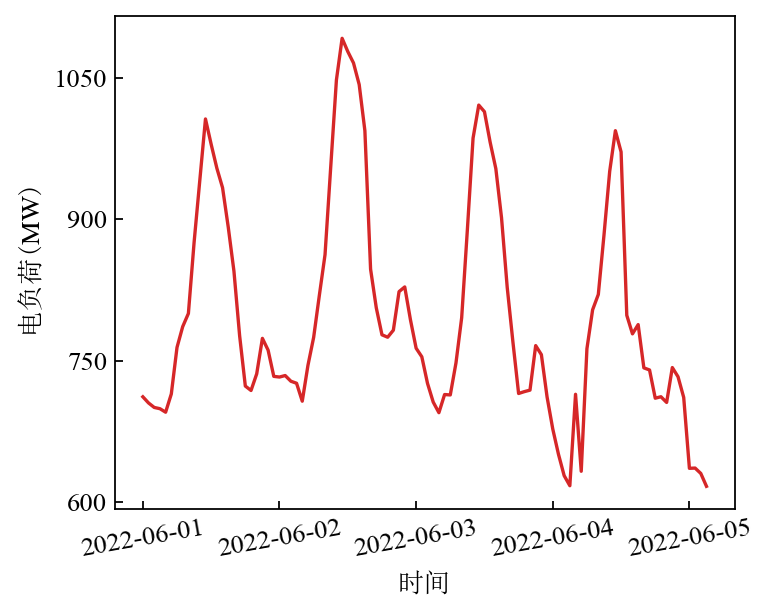

In [75]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdate
import matplotlib.ticker as ticker

# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5, 4))
ax = fig.add_subplot(111)
ax.plot(load_data['load'][0:100], color=color_list[4], linestyle='-', linewidth=1.5)  # 真实值

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
# ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d %H'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(10)
legend_font = {"family":"SimSun", "size":10}
ax.set_ylabel('电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
# ax.set_ylim([15,30])
# plt.legend(['观测值', '中位数', '99% 预测区间', '90% 预测区间', '50% 预测区间'],frameon=False, fontsize=10, bbox_to_anchor=(1.001, 1.02), prop=legend_font)

<Axes: xlabel='temp', ylabel='load'>

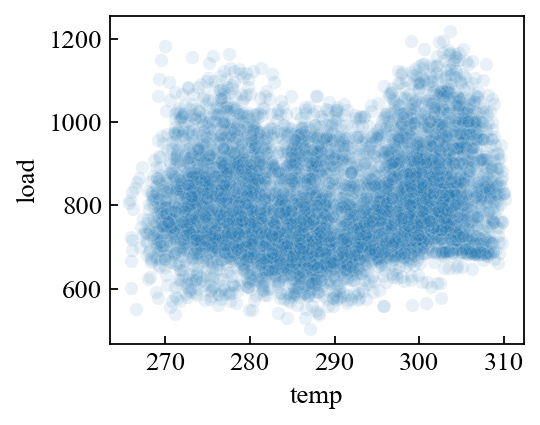

In [80]:
import seaborn as sns

# create figure
config = {
"font.family":'serif',  
"font.size": 12,    
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.family":"times new roman",
}

rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)
x=load_data['temp']
y=load_data['load']
sns.scatterplot(x=x, y=y, alpha=0.1)


### 构造输入输出数据

In [38]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
data = load_data.loc['2022-06-1 00:00:00':]
print(f"数据集大小： {data.shape}")
data = data.astype(dict(hour=str, week=str, month=str))
time_varying_known_categoricals = ['hour', 'week', 'month']
time_varying_known_reals = ['temp', 'precipitation', 'pressure']
encoder_length = 72
decoder_length = 24
train_dataset = TimeSeriesDataSet(
    data=data[lambda x: x.Time_index < 520],
    time_idx="Time_index",
    target="load",
    group_ids=["month"],
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=time_varying_known_categoricals,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["load"],
    max_encoder_length=encoder_length,
    max_prediction_length=decoder_length,
    allow_missing_timesteps=True,
    target_normalizer=EncoderNormalizer(transformation='relu', method='standard')
)
val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, data[lambda x: x.Time_index < 620], min_prediction_idx=520)
test_dataset = TimeSeriesDataSet.from_dataset(train_dataset, data, min_prediction_idx=620)

# seed=20
# setup_seed(seed)

batch_size = 128
train_dl = train_dataset.to_dataloader(train=True,
                                       num_workers=0,
                                       batch_sampler=BatchSampler(RandomSampler(train_dataset),
                                                                  batch_size=batch_size,
                                                                  drop_last=True),
                                       )

val_dl = val_dataset.to_dataloader(train=True,
                                   num_workers=0,
                                   batch_sampler=BatchSampler(SequentialSampler(val_dataset),
                                                              batch_size=batch_size,
                                                              drop_last=False)
                                   )

test_dl = test_dataset.to_dataloader(train=False,
                                     num_workers=0,
                                     batch_sampler=BatchSampler(SequentialSampler(test_dataset),
                                                                batch_size=batch_size,
                                                                drop_last=False)
                                     )

数据集大小： (7272, 10)


In [20]:
print(len(train_dl), len(val_dl), len(test_dl))

31 7 9


In [39]:
### 定义模型
class MyDeepARN(MyDeepAR):
    def __init__(self, **kwgs):
        super().__init__(**kwgs)
        self.min_loss = 10e6
        self.early_stop_sign = 0
        
    def construct_input_vector(self, x_cat: torch.Tensor, x_cont: torch.Tensor, one_off_target: torch.Tensor = None):
        # embedding x_cat
        embeddings = {name: self.embeddings[name](x_cat[..., i]) for i, name in enumerate(self.categoricals)}
        flat_embeddings = torch.cat([embeddings[name] for name in self.categoricals], dim=-1)

        # concat with x_cont
        input_vector = torch.cat([x_cont, flat_embeddings], dim=-1)

        # shift target by one
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        if one_off_target is not None:  # set first target input (which is rolled over)
            input_vector[:, 0, self.target_positions] = one_off_target
        else:
            input_vector = input_vector[:, 1:]
        # shift target
        return input_vector


    def decode(self,
               input_vector: torch.Tensor,
               target_scale: torch.Tensor,
               hidden_state,
               n_samples: int = None,) -> torch.Tensor:
        if n_samples is None:
            # run in train and validation
            output, _ = self.rnn(input_vector, hidden_state)  # LSTM decoder process
            output = self.distribution_projector(output)  # Liner projector process
            # every batch to scale  [target_scale[0], target_scale[1], loc, scale(softplus_function)]
            output = self.loss.rescale_parameters(parameters=output,
                                                  target_scale=target_scale,
                                                  encoder=self.output_transformer)
        else:
            # run in test and validation
            # for every batch，sample n_samples, get n_samples trace
            target_pos = self.target_positions
            # repeat for n_samples
            input_vector = input_vector.repeat_interleave(n_samples, dim=0)  # [n_samples*batch, t, f]
            hidden_state = self.LSTMrepeat_interleave(hidden_state, n_samples)
            target_scale = target_scale.repeat_interleave(n_samples, 0)  # [6400,2]

            # define function to run at every decoding step
            def decode_one(idx, lagged_targets, hidden_state_one):
                x = input_vector[:, [idx]]  # 获得当前步的inputs
                x[:, 0, target_pos] = lagged_targets[-1]  # 使用预测norm的结果替换
                decoder_output, hidden_state_one = self.rnn(x, hidden_state_one)  # LSTM
                prediction = self.distribution_projector(decoder_output)  # gaussian 分布，还要log(1+exp(\sigma))
                prediction = prediction[:, 0]  # select first time step
                return prediction, hidden_state_one

            # make predictions which are fed into next step
            output = self.decode_autoregressive(
                decode_one,
                first_target=input_vector[:, 0, target_pos],  #
                first_hidden_state=hidden_state,
                target_scale=target_scale,
                n_decoder_steps=input_vector.size(1),  # time step
                n_samples=n_samples,
            )
            # reshape predictions for n_samples:
            # from n_samples * batch_size x time steps to batch_size x time steps x n_samples
            output = output.reshape(-1, n_samples, input_vector.size(1)).permute(0, 2, 1)
        return output
    
    
    def training_step(self, batch, device):
        # encode
        x, y = batch
        input_vector = self.construct_input_vector(x["encoder_cat"], x["encoder_cont"])
        _, hidden_state = self.rnn(input_vector.to(device))
        # decode
        one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
        input_vector = self.construct_input_vector(x["decoder_cat"],   # [64,24,18]
                                                   x["decoder_cont"],
                                                   one_off_target)
        
        y_hat = self.decode(input_vector=input_vector.to(device),
                    target_scale=x['target_scale'].to(device),  # [64, 2]
                    hidden_state=hidden_state,
                    n_samples=None)
        y_true, _ = y  # [64, 24] (y_hat_orspace - y[0]).abs().mean()
        loss = self.loss.loss(y_hat, y_true.to(self.device)).sum()
        return loss, y_true.numel()

        
    def mask_p(self, epoch):
        p = min(1, 0+epoch*1/7/38)
        return p

    def ss_training_step(self, batch, epoch, batch_idx, device):
        # encode
        if batch_idx%10 ==0 :
            print('pk:',self.mask_p((epoch-1)*38+batch_idx))
        self.train()
        x, y = batch
        input_vector = self.construct_input_vector(x["encoder_cat"].clone(), x["encoder_cont"].clone())
        _, hidden_state = self.rnn(input_vector.to(device))
        # decode
        one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
        input_vector = self.construct_input_vector(x["decoder_cat"].clone(),   # [64,24,18]
                                                   x["decoder_cont"].clone(),
                                                   one_off_target)
        # 迭代每个时间步，并用预测值替换掉x中的values
        y_hat = input_vector[:, 0, self.target_positions].to(device)  # 初始化y_hat [64,1]
        out_dist = []
        for t in range(input_vector.shape[1]):
            input_vector_t = input_vector[:, [t], :].clone().to(device)  # 64,1,18
            mask = torch.rand(input_vector.shape[0], 1).to(device) < self.mask_p((epoch-1)*38+batch_idx)  # 设置选择概率，采用mask
            input_vector_t[..., 0, self.target_positions][mask] = y_hat[mask]

            # 预测
            output, hidden_state = self.rnn(input_vector_t, hidden_state)
            output = self.distribution_projector(output)  # Liner projector process
            # every batch to scale  [target_scale[0], target_scale[1], loc, scale(softplus_function)]
            # 保存每一步得到的分布，用于计算loss  (64,1,4)
            output = self.loss.rescale_parameters(parameters=output,
                                                  target_scale=x['target_scale'].to(device), # [64, 2]
                                                  encoder=self.output_transformer)
            # 预测得到分布 采样获得100个值  output
            dist = self.loss.map_x_to_distribution(output)
            samples = dist.sample((100, ))  # (100, 64, 1)
            samples = samples.permute(1, 0, 2).mean(1)   # (64, 1)
            # [batch*n_samples, 1， 1] 为后面scale
            # normalize prediction prediction   # (64, 1)
            y_hat = self.output_transformer.transform(samples,
                                                      target_scale=x['target_scale'].to(device))   # EncoderNormal
            y_hat.detach_()
            out_dist.append(output.squeeze())

        out_dist = torch.stack(out_dist, dim=1)
        # 计算loss
        # loss
        y_true, _ = y  # [64, 24]
        # distribution = self.map_x_to_distribution(y_pred)
        # loss = -distribution.log_prob(y_actual)
        loss = self.loss.loss(out_dist, y_true.to(self.device)).sum()
        return loss, y_true.numel(), self.mask_p(epoch) 
            
            
            
            
            
    def re_training_step(self, batch, device):
        x, y = batch
        one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
        # 预测结果
        # input_vector = self.construct_input_vector(x["encoder_cat"], x["encoder_cont"])
        with torch.no_grad():
            self.eval()
            # encode
            input_vector = self.construct_input_vector(x["encoder_cat"].clone(), x["encoder_cont"].clone())
            _, hidden_state = self.rnn(input_vector.to(device))
            # decode
            input_vector = self.construct_input_vector(x["decoder_cat"].clone(),   # [64,24,18]
                                                       x["decoder_cont"].clone(),
                                                       one_off_target)
            y_hat = self.decode(input_vector=input_vector.to(self.device),
                        target_scale=x['target_scale'].to(self.device),  # [64, 24, 4]
                        hidden_state=hidden_state,
                        n_samples=None)
            
            # 替换掉真实值
            # y_hat_scale = (y_hat.mean(-1) - x['target_scale'][..., [0]]) / x['target_scale'][..., [1]]
            y_hat_scale = y_hat[..., 2]
            x_decoder_cont = x['decoder_cont'].clone()
            x_decoder_cont[...,self.target_positions.item()] = y_hat_scale

        # 再训练
        self.train()
        # input_vector = self.construct_input_vector(x["encoder_cat"], x["encoder_cont"])
        # _, hidden_state = self.rnn(input_vector.to(device))      
        
        input_vector = self.construct_input_vector(x["decoder_cat"].clone(),   # [64,24,18]
                                           x_decoder_cont,
                                           one_off_target)
        
        y_hat = self.decode(input_vector=input_vector.to(device),
                    target_scale=x['target_scale'].to(device),  # [64, 24, 4]
                    hidden_state=hidden_state,
                    n_samples=None)
            
        y_true, _ = y  # [64, 24] (y_hat_orspace - y[0]).abs().mean()
        loss = self.loss.loss(y_hat, y_true.to(self.device)).sum()
        return loss, y_true.numel()


    def validation_step(self, batch, device):
        # encode
        x, y = batch
        input_vector = self.construct_input_vector(x["encoder_cat"], x["encoder_cont"])
        _, hidden_state = self.rnn(input_vector.to(device))
        # deocode
        one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
        input_vector = self.construct_input_vector(x["decoder_cat"],
                                                   x["decoder_cont"],
                                                   one_off_target)

        y_hat = self.decode(input_vector=input_vector.to(device),   # [64, 24, 4]
                            target_scale=x['target_scale'].to(device),
                            hidden_state=hidden_state,
                            n_samples=None)
        y_true, _ = y  # [64, 24] (y_hat_orspace - y[0]).abs().mean()
        loss = self.loss.loss(y_hat, y_true.to(self.device)).sum()
        return loss, y_true.numel()

    def prediction(self, test_dl, n_samples=100):
        out = []
        x_list = []
        y_list = []
        y_pred_list = []
        decoder_y = []
        encoder_y = []
        decoder_cat = []
        decoder_time_index = []
        
        self.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(test_dl):
                # encode
                x, y = batch
                input_vector = self.construct_input_vector(x["encoder_cat"].clone(), x["encoder_cont"].clone())
                _, hidden_state = self.rnn(input_vector.to(device))
            
                one_off_target = x["encoder_cont"][:, -1, self.target_positions.unsqueeze(-1)].reshape(-1, 1)
                input_vector = self.construct_input_vector(x["decoder_cat"].clone(),
                                                           x["decoder_cont"].clone(),
                                                           one_off_target)

                y_hat = self.decode(input_vector=input_vector,  # [64, 24, 100]
                                    target_scale=x['target_scale'].clone(),
                                    hidden_state=hidden_state,
                                    n_samples=n_samples)
                
                # y_hat_orspace = (y_hat[..., 2] * y_hat[..., 1] + y_hat[..., 0] - y[0]).abs()
                
                out.append(y_hat)  # 记录预测结果
                decoder_y.append(y[0])  # 记录真实的y
                encoder_y.append(x['encoder_target'])  # 记录encoder部分的值
#                 x_list.append(x)  # 保存x
#                 y_list.append(y)  # 保存y
                decoder_cat.append(x['decoder_cat'])
                decoder_time_index.append(x['decoder_time_idx'])

               
                
            out = torch.cat(out, dim=0)
            decoder_y = torch.cat(decoder_y, dim=0)
            encoder_y = torch.cat(encoder_y, dim=0)
            decoder_cat = torch.cat(decoder_cat, dim=0)
            decoder_time_index = torch.cat(decoder_time_index, dim=0)
        return out, decoder_y, encoder_y, (decoder_cat,decoder_time_index) # , x_list, y_list


In [40]:
# 评价测试集
def val_epoch_loss(data_iter, net, device=None):
    if device is None:
        device = list(net.parameters())[0].device
        
    loss_sum, n = 0.0, 0
    with torch.no_grad():
        for batch in data_iter:
            net.eval()
            l, ynumel = net.validation_step(batch, device)
            loss_sum += l.cpu().item()
            n += ynumel
            
    return loss_sum / n



def call_save_model(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR.pth")
        print(f'call:{val_loss}')
    
    
def call_early_stop(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR.pth")
        print(f'call:{val_loss}')
        net.early_stop_sign = 0
    else:
        net.early_stop_sign += 1
 #       torch.save(net.state_dict(), "model/DeepAR.pth")
        
    if net.early_stop_sign >= 5:
        return True
    else:
        return False

    
def train_net(net, train_iter, test_iter, optimizer, device, epochs):
    global seed
    net = net.to(device)
    test_loss_list = []
    train_loss_list = []
    
    for epoch in range(1, epochs+1):
        # setup_seed(seed+epoch)
        train_l_sum, train_mae_sum, n, start = 0.0, 0.0, 0, time.time()
        for batch in train_iter:
        
            net.train()
            l, ynumel = net.training_step(batch, device)
        
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            with torch.no_grad():        
                train_l_sum += l.cpu().item()
                n += ynumel
        test_loss = val_epoch_loss(test_iter, net, device) 
    
        test_loss_list.append(test_loss)
        train_loss_list.append(train_l_sum/n) 
        
        print('epoch %d, train loss %.4f, test loss %.3f, time %.2f sec'
              % (epoch, train_l_sum/n, test_loss, time.time() - start))

        # 保存模型
        # call_save_model(net,  test_mae)
        early_stop = call_early_stop(net, test_loss)
        if early_stop:
            break
        
    torch.save(torch.tensor(train_loss_list), "loss/DeepAR_train_loss.pt")
    torch.save(torch.tensor(test_loss_list), "loss/DeepAR_val_loss.pt")


import os
batch_size = 128
train_dl = train_dataset.to_dataloader(train=True,
                                       num_workers=0,
                                       batch_sampler=BatchSampler(RandomSampler(train_dataset),
                                                                  batch_size=batch_size,
                                                                  drop_last=True),
                                       )

val_dl = val_dataset.to_dataloader(train=True,
                                   num_workers=0,
                                   batch_sampler=BatchSampler(SequentialSampler(val_dataset),
                                                              batch_size=batch_size,
                                                              drop_last=False)
                                   )

In [41]:
# seed=0

# np.random.seed(seed) 
# random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)  # 禁止hash随机化
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # 在cuda 10.2及以上的版本中，需要设置以下环境变量来保证cuda的结果可复现
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed) # 多GPU训练需要设置这个
# torch.manual_seed(seed)
# torch.use_deterministic_algorithms(True) # 一些操作使用了原子操作，不是确定性算法，不能保证可复现，设置这个禁用原子操作，保证使用确定性算法
# torch.backends.cudnn.deterministic = True  # 确保每次返回的卷积算法是确定的
# torch.backends.cudnn.enabled = False  # 禁用cudnn使用非确定性算法
# torch.backends.cudnn.benchmark = False  # 与上面一条代码配

device = torch.device('cpu')
print('training on', device)

# 保存模型的embeddings，接下来所有模型使用相同的embedding
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
embeddings = net.embeddings
torch.save(embeddings,"model/embeddings.pth" )
embeddings = torch.load("model/embeddings.pth")
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epochs = 50
train_net(net, train_dl, val_dl, optimizer, device, epochs)

training on cpu
epoch 1, train loss 6.0400, test loss 5.565, time 5.35 sec
call:5.565044721793303
epoch 2, train loss 5.4056, test loss 5.231, time 5.36 sec
call:5.230928734783486
epoch 3, train loss 5.1396, test loss 5.208, time 5.35 sec
call:5.207789743101442
epoch 4, train loss 5.0390, test loss 5.228, time 5.31 sec
epoch 5, train loss 4.9650, test loss 5.298, time 5.35 sec
epoch 6, train loss 4.9043, test loss 5.336, time 5.41 sec
epoch 7, train loss 4.8374, test loss 5.369, time 5.49 sec
epoch 8, train loss 4.7925, test loss 5.535, time 5.42 sec


In [42]:
# 加载最新模型
# 加载模型
device = torch.device('cpu')
embeddings = torch.load("model/embeddings.pth")
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
net.load_state_dict(torch.load("model/DeepAR.pth"))


r = 0.9
# 预测
out, y_true, encoder_y, (decoder_cat, decoder_time_index) = net.prediction(test_dl, n_samples=100)
y_mean = net.to_prediction(out, use_metric=False)  # mean
mape = met.MAPE(y_mean, y_true)
mae = met.MAE(y_mean, y_true)
index = [0, 5, 11, 16, 23]
print(f'net1 MAE:{[mae[i].item() for i in index]}, mean:{mae.mean().item()}')
print(f'net1 MAPE:{[mape[i].item() for i in index]}, mean:{mape.mean().item()}')

net1 MAE:[33.5184211730957, 40.51741409301758, 43.72872543334961, 44.68803405761719, 45.44568634033203], mean:42.29027557373047
net1 MAPE:[4.212211608886719, 5.053769588470459, 5.414363384246826, 5.54234504699707, 5.729802131652832], mean:5.270727634429932


In [43]:
import time

def call_save_model(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR_retrain.pth")
        print(f'call:{val_loss}')
    

def call_early_stop(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR_retrain.pth")
        print(f'call:{val_loss}')
        net.early_stop_sign = 0
    else:
        net.early_stop_sign += 1
        
    if net.early_stop_sign >= 5:
        return True
    else:
        return False

    
def re_train_net(net, train_iter, test_iter, optimizer, device, epochs):
    global seed
    net = net.to(device)
    test_loss_list = []
    train_loss_list = []
    
    for epoch in range(1, epochs+1):
        # setup_seed(seed+epoch)
        train_l_sum, train_mae_sum, n, start_time = 0.0, 0.0, 0, time.time()
        for batch in train_iter:
        
            net.train()
            l, ynumel = net.re_training_step(batch, device)
        
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            with torch.no_grad():        
                train_l_sum += l.cpu().item()
                n += ynumel
        test_loss = val_epoch_loss(test_iter, net, device) 
    
        test_loss_list.append(test_loss)
        train_loss_list.append(train_l_sum/n) 
        
        print('epoch %d, train loss %.4f, test loss %.3f, time %.2f sec'
              % (epoch, train_l_sum/n, test_loss, time.time() - start_time))

        # 保存模型
#        call_save_model(net, test_loss)
        early_stop = call_early_stop(net, test_loss)
        if early_stop:
            break
        
    torch.save(torch.tensor(train_loss_list), "loss/DeepAR_re_train_loss.pt")
    torch.save(torch.tensor(test_loss_list), "loss/DeepAR_re_val_loss.pt")

batch_size = 128
train_dl = train_dataset.to_dataloader(train=True,
                                       num_workers=0,
                                       batch_sampler=BatchSampler(RandomSampler(train_dataset),
                                                                  batch_size=batch_size,
                                                                  drop_last=True),
                                       )

val_dl = val_dataset.to_dataloader(train=True,
                                   num_workers=0,
                                   batch_sampler=BatchSampler(SequentialSampler(val_dataset),
                                                              batch_size=batch_size,
                                                              drop_last=False)
                                   )

print('training on', device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epochs = 20
net.train()
re_train_net(net, train_dl, val_dl, optimizer, device, epochs)

training on cpu
epoch 1, train loss 5.1608, test loss 5.183, time 4.94 sec
call:5.1827546751344356
epoch 2, train loss 5.1115, test loss 5.194, time 4.86 sec
epoch 3, train loss 5.0622, test loss 5.227, time 4.99 sec
epoch 4, train loss 5.0288, test loss 5.256, time 4.65 sec
epoch 5, train loss 4.9884, test loss 5.323, time 4.64 sec
epoch 6, train loss 4.9579, test loss 5.440, time 4.55 sec


### 绘制多步预测结果并画图

In [52]:
def get_quantile_loss(r, net, out, y_true):
    net.loss.quantiles = [r]
    y_quantiles = net.to_quantiles(out, use_metric=False)
    y_quantiles.squeeze_()
    def quantile_loss(y_true, y_hat, r):
        mae = (y_true-y_hat).abs()
        loss = (2*(1-r)*mae[y_hat>y_true]).sum() + (2*(r)*mae[y_hat<=y_true]).sum()
        loss = loss/y_true.numel()
        # 归一化
        # loss = loss/y_true.mean()
        return loss
    return torch.tensor([quantile_loss(y_true[:, t], y_quantiles[:, t], 0.9) for t in range(0, 24)])


r = 0.9
seed = 12
### 加载模型
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
net.load_state_dict(torch.load("model/DeepAR.pth"))
# 预测
out, y_true, encoder_y, (decoder_cat, decoder_time_index) = net.prediction(test_dl, n_samples=100)
y_mean = net.to_prediction(out, use_metric=False)  # mean
mape = met.MAPE(y_mean, y_true)
mae = met.MAE(y_mean, y_true)
index = [0, 5, 11, 16, 23]
print(f'net1 MAE:{[mae[i].item() for i in index]}, mean:{mae.mean().item()}')
print(f'net1 MAPE:{[mape[i].item() for i in index]}, mean:{mape.mean().item()}')
torch.save(mae, f"loss/mae_deepar_seed{seed}.pt")
# 分位数损失
qloss = get_quantile_loss(r, net, out, y_true)
print(f'net1 Qloss:{[qloss[i].item() for i in index]}, mean:{qloss.mean().item()}')
torch.save(qloss, f"loss/qloss_deepar_seed{seed}.pt")


net1 MAE:[33.384586334228516, 40.57088088989258, 43.77461624145508, 44.58281707763672, 45.20505905151367], mean:42.29396057128906
net1 MAPE:[4.192479133605957, 5.060892581939697, 5.417728424072266, 5.522943496704102, 5.70166540145874], mean:5.270238399505615
net1 Qloss:[15.113607406616211, 18.123777389526367, 19.600215911865234, 19.83683967590332, 19.782859802246094], mean:18.83341407775879


Text(0.5, 0, '预测步数')

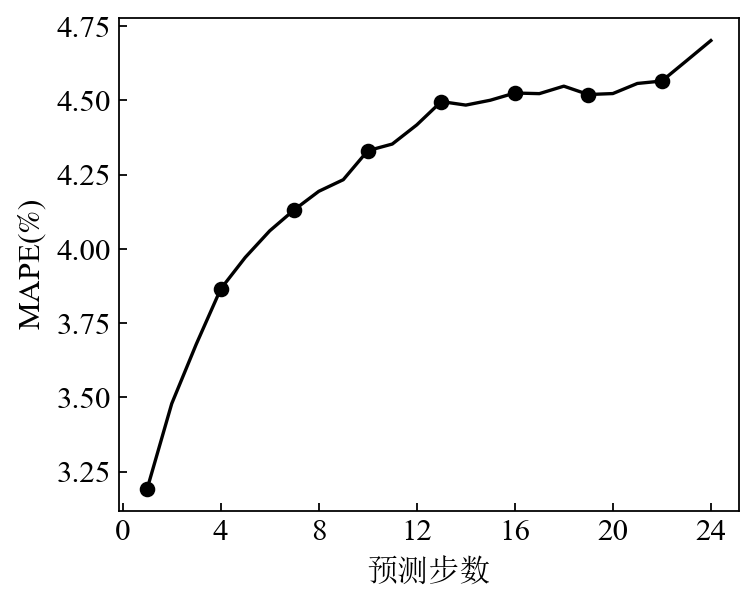

In [106]:
# create figure
config = {
"font.family":'serif',  
"font.size": 14,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5, 4))
ax = fig.add_subplot(111)
ax.plot(np.arange(1,25) , mape-1, color='k', linestyle='-', linewidth=1.5)  # 真实值
ax.scatter(np.arange(1,25,3) , (mape-1)[::3], color='k', marker='o')  # 真实值

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
# ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d %H'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
legend_font = {"family":"SimSun", "size":10}
ax.set_ylabel('MAPE($\mathrm{\%}$)', fontfamily="Times New Roman")
ax.set_xlabel('预测步数', fontfamily="SimSun")
# ax.set_ylim([15,30])
# plt.legend(['观测值', '中位数', '99% 预测区间', '90% 预测区间', '50% 预测区间'],frameon=False, fontsize=10, bbox_to_anchor=(1.001, 1.02), prop=legend_font)

### 绘制预测结果

In [107]:
# 画图，多步预测结果展示和loss收敛过程
device = torch.device('cpu')
net = MyDeepARN.from_dataset(train_dataset, hidden_size=64, layers=2, dropout=0.1, device=device)
net.embeddings = embeddings
net.load_state_dict(torch.load("model/DeepAR_retrain.pth"))
# 预测
out, y_true, encoder_y, (decoder_cat, decoder_time_index) = net.prediction(test_dl, n_samples=100)
encoder_target = encoder_y
decoder_target = y_true
y_hats = net.to_prediction(out, use_metric=False)  # mean

net.loss.quantiles = [0.005,0.05, 0.25, 0.75, 0.95, 0.995]
y_quantiles = net.to_quantiles(out, use_metric=False)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdate
import matplotlib.ticker as ticker

def get_time_range(idx):
    hour_label = train_dataset.categorical_encoders['hour']
    week_label = train_dataset.categorical_encoders['week']
    month_label = train_dataset.categorical_encoders['month']

    hours = hour_label.inverse_transform(decoder_cat[idx, :, 0]).astype(int)
    weeks = week_label.inverse_transform(decoder_cat[idx, :, 1]).astype(int)
    months = month_label.inverse_transform(decoder_cat[idx, :, 2]).astype(int)
    day = int(decoder_time_index[idx,:][0]/24)+1
    start_point = pd.Timestamp(year=2022, month=months[0], day=day,  hour=hours[0])
    time_pred =  pd.to_datetime(np.arange(0,24), unit='h', origin=start_point)
    time_start = time_pred.shift(-72, freq='h')
    for t in [-48,-24, 0]:
        time_start = time_start.append(time_pred.shift(t, freq='h'))
    return time_start

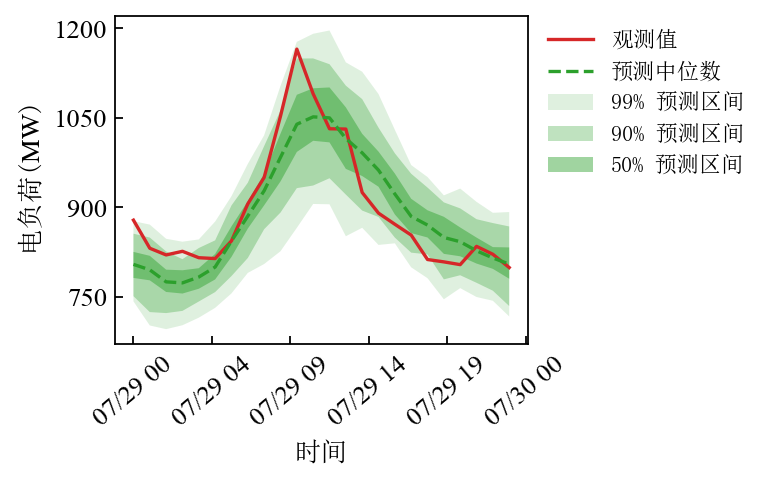

In [164]:

# create figure
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
fig = plt.figure(dpi=160, figsize=(5/1.5, 4/1.5))
ax = fig.add_subplot(111)


idx = 15 +24*32# 画图的id  720 150 60
y = torch.cat([encoder_target[idx], decoder_target[idx]])  # 真实值序列
# move predictions to cpu
y_hat = y_hats.detach().cpu()[idx, : decoder_target.shape[1]]  # 预测序列
y_quantile = y_quantiles.detach().cpu()[idx, : decoder_target.shape[1]]   # 预测分位数序列
y, y_hat, y_quantile = y, y_hat, y_quantile

time_range = get_time_range(idx)
pred_len = 24
x_pred = time_range[-pred_len:]
#ax.plot(time_range[48:-pred_len], y[48:-pred_len], color=color_list[4], linestyle='-', linewidth=1.5)
ax.plot(x_pred, y[-pred_len:], color=color_list[4], linestyle='-', linewidth=1.5)  # 真实值
ax.plot(x_pred, y_hat, color=color_list[3], linestyle='--', linewidth=1.5)

# plot predicted quantiles
# ax.plot(x_pred, y_quantile[:, y_quantile.shape[1] // 2], c=color_list[0], alpha=0.15, label='0.9')
alphas = np.array([0.15, 0.3, 0.45, 0.65])*1
for i in range(y_quantile.shape[1] // 2):
    if len(x_pred) > 1:
        ax.fill_between(x_pred, y_quantile[:, i], y_quantile[:, -i - 1], alpha=alphas[i], fc=color_list[3])
    else:
        quantiles = torch.tensor([[y_quantile[0, i]], [y_quantile[0, -i - 1]]])
        ax.errorbar(
            x_pred,
            y[[-n_pred]],
            yerr=quantiles - y[-n_pred],
            c=color_list[3],
            capsize=1.0,
        )
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(150))
ax.xaxis.set_major_formatter(mdate.DateFormatter('%m/%d %H'))  # 横坐标标签显示的日期格式
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
legend_font = {"family":"SimSun", "size":10}
ax.set_ylabel('电负荷($\mathrm{MW}$)', fontfamily="SimSun")
ax.set_xlabel('时间', fontfamily="SimSun")
# ax.set_ylim([15,30])
plt.legend(['观测值', '预测中位数', '99% 预测区间', '90% 预测区间', '50% 预测区间'],frameon=False, fontsize=10, bbox_to_anchor=(1.001, 1.02), prop=legend_font)